In [1]:
# Import and preprocess data
import pandas as pd
dataset = pd.read_csv('realwage2.csv', usecols = ['Country', 'Year', 'CPI', 'PLI', 'PES', 'LPU', 'GDPPH', 'RMW'],\
 index_col = ['Country', 'Year'])
years = dataset.index.get_level_values('Year').to_list()
dataset['Year'] = pd.Categorical(years)
dataset.head()

CPI  PLI    PES       LPU      GDPPH       RMW  Year
Country   Year                                                           
Australia 2001  4.407135   77  0.144  3.480771  83.805503  21665.65  2001
          2002  2.981575   81  0.143  1.515225  85.075345  21879.08  2002
          2003  2.732596   91  0.140  2.311750  87.042074  22164.56  2003
          2004  2.343255   99  0.137 -0.335447  86.750094  22553.58  2004
          2005  2.691832  104  0.134  0.358355  87.060967  22736.45  2005

In [2]:
# Perform PooledOLS
import statsmodels.api as sm
from linearmodels import PooledOLS

exo = dataset[['CPI', 'PLI', 'PES', 'LPU', 'GDPPH']]
exog = sm.tools.tools.add_constant(exo)
"""exog = sm.tools.tools.add_constant(dataset['CPI'])
exog = sm.tools.tools.add_constant(dataset['PLI'])
exog = sm.tools.tools.add_constant(dataset['PES'])
exog = sm.tools.tools.add_constant(dataset['LPU'])
exog = sm.tools.tools.add_constant(dataset['GDPPH'])"""

endog = dataset['RMW']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

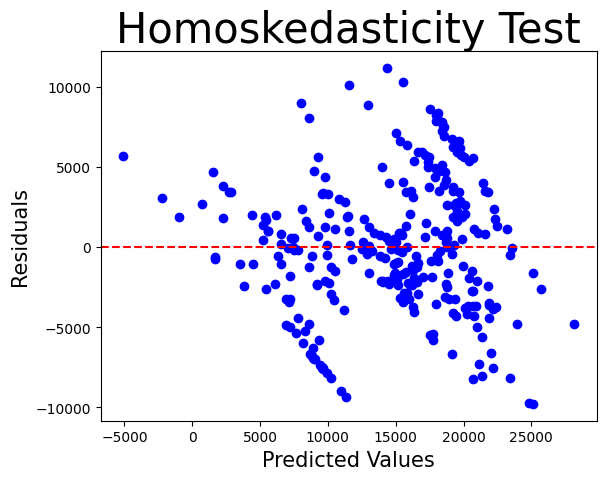

In [3]:
# Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [4]:
# White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['Year'], axis = 1).fillna(0)

exo = dataset[['CPI', 'PLI', 'PES', 'LPU', 'GDPPH']]
exog = sm.tools.tools.add_constant(exo)

white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print('White-Test: ')
print(dict(zip(labels, white_test_results)))

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print('Breusch-Pagan-Test: ')
print(dict(zip(labels, breusch_pagan_test_results)))

print('\nIn simple terms, if p < 0.05, then heteroskedasticity is indicated.')
print('\nA low p-value in F-stat counts against the null hypothesis that the pooled OLS model is adequate, in favor of the random effects alternative.')

print('\nA low p-value in Breusch-Pagan-Test counts against the null hypothesis that the pooled OLS model is adequate, in favor of the random effects alternative.')

White-Test: 
{'LM-Stat': 58.47100190602048, 'LM p-val': 1.2247535685568967e-05, 'F-Stat': 3.388666289399806, 'F p-val': 2.920428435115527e-06}
Breusch-Pagan-Test: 
{'LM-Stat': 27.013121679026007, 'LM p-val': 5.6707813039332925e-05, 'F-Stat': 5.82783625359039, 'F p-val': 3.806340151060878e-05}

In simple terms, if p < 0.05, then heteroskedasticity is indicated.

A low p-value in F-stat counts against the null hypothesis that the pooled OLS model is adequate, in favor of the random effects alternative.

A low p-value in Breusch-Pagan-Test counts against the null hypothesis that the pooled OLS model is adequate, in favor of the random effects alternative.


In [5]:
# Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print("Durbin-Watson-Test Result: ",durbin_watson_test_results)

print('\nThe Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation).')

Durbin-Watson-Test Result:  0.2612558718600717

The Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation).


In [7]:
# PooledOLS,FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PooledOLS



exog_var = ['CPI', 'PLI', 'PES', 'LPU', 'GDPPH']
exog = sm.tools.tools.add_constant(dataset[exog_var])

endog = dataset['RMW']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 

mod = PooledOLS(endog, exog)
pool_res = mod.fit()

#print results
print(pool_res)
print(re_res)
print(fe_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                    RMW   R-squared:                        0.6596
Estimator:                  PooledOLS   R-squared (Between):              0.7587
No. Observations:                 294   R-squared (Within):              -0.6066
Date:                Sun, Jan 22 2023   R-squared (Overall):              0.6596
Time:                        19:12:48   Log-likelihood                   -2866.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      111.61
Entities:                          14   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(5,288)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):             111.61
                            

In [135]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B))
    pval = stats.chi2.sf(chi2, df)
    
    return chi2, df, pval
    
    
hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

print('\nA low p-value counts against the null hypothesis that the random effects model is consistent, in favor of the fixed effects model.')

chi-Squared: -10.435137932663718
degrees of freedom: 6
p-Value: 1.0

A low p-value counts against the null hypothesis that the random effects model is consistent, in favor of the fixed effects model.


Text(0.5, 1.0, 'Correlation of Variables')

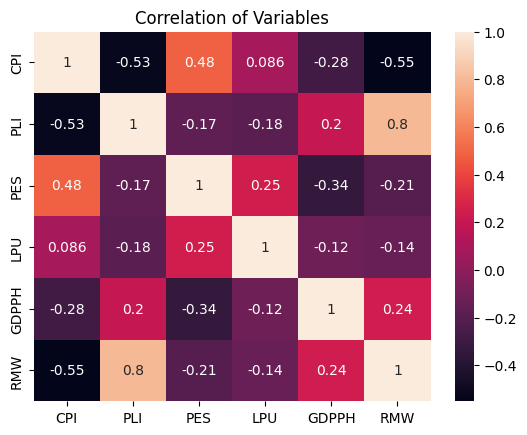

In [136]:
# Correlation
import pandas as pd
import seaborn as sns

corr_matrix = dataset.corr()

sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation of Variables')


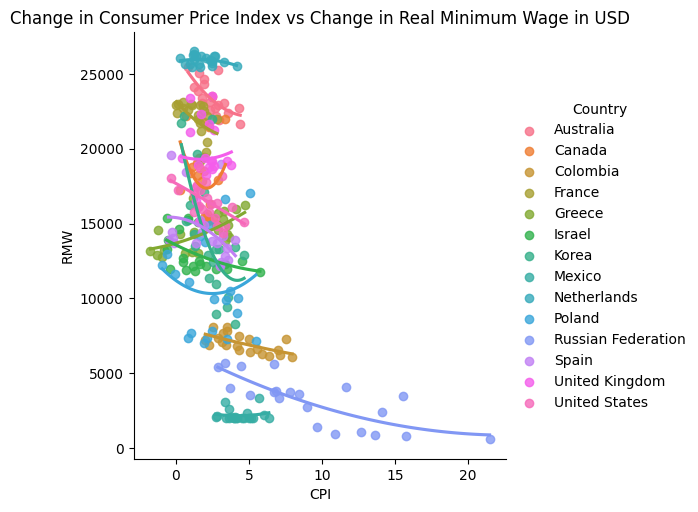

In [137]:
# Consumer Price Index

sns.lmplot(x="CPI", y="RMW", data=df_panel, hue='Country',
   order=2, ci=False).set(title=                 
                'Change in Consumer Price Index vs Change in Real Minimum Wage in USD')

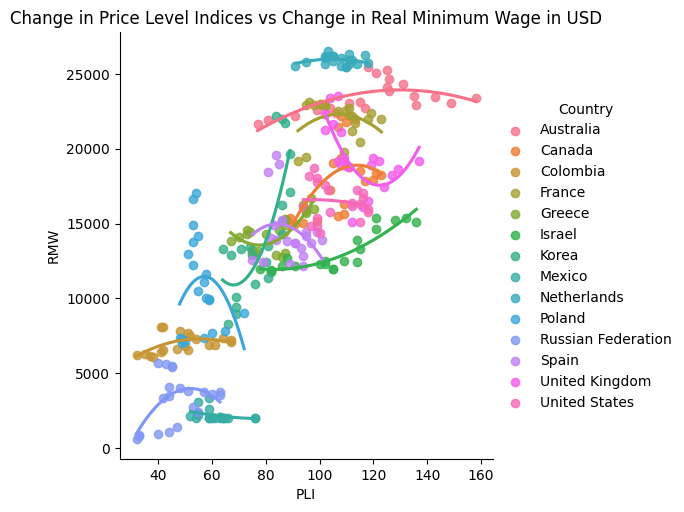

In [138]:
# Price Level Indices

sns.lmplot(x="PLI", y="RMW", data=df_panel, hue='Country',
   order=2, ci=False).set(title=                 
                'Change in Price Level Indices vs Change in Real Minimum Wage in USD')

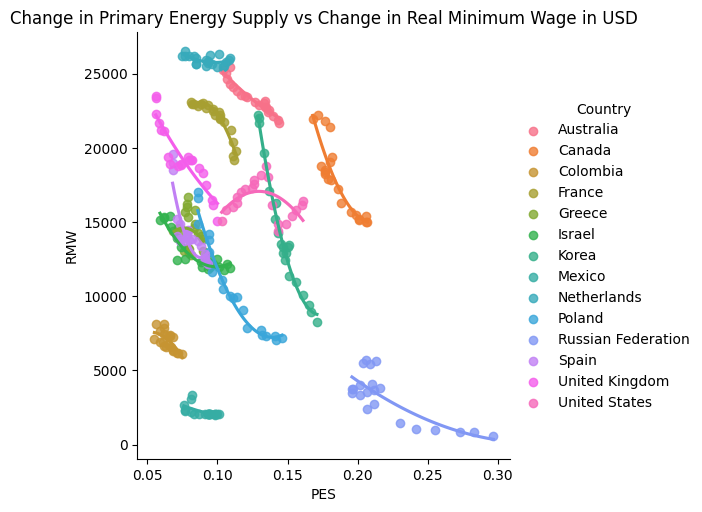

In [139]:
# Primary Energy Supply

sns.lmplot(x="PES", y="RMW", data=df_panel, hue='Country',
   order=2, ci=False).set(title=                 
                'Change in Primary Energy Supply vs Change in Real Minimum Wage in USD')

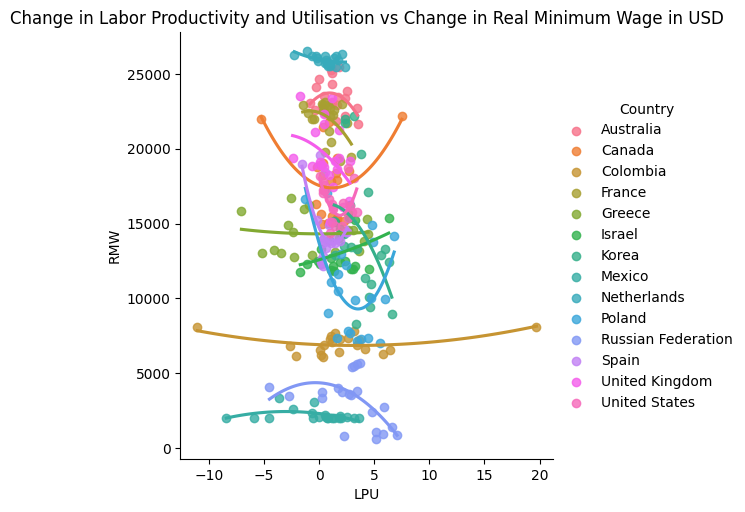

In [140]:
# Labor Productivity and Utilisation

sns.lmplot(x="LPU", y="RMW", data=df_panel, hue='Country',
   order=2, ci=False).set(title=                 
                'Change in Labor Productivity and Utilisation vs Change in Real Minimum Wage in USD')

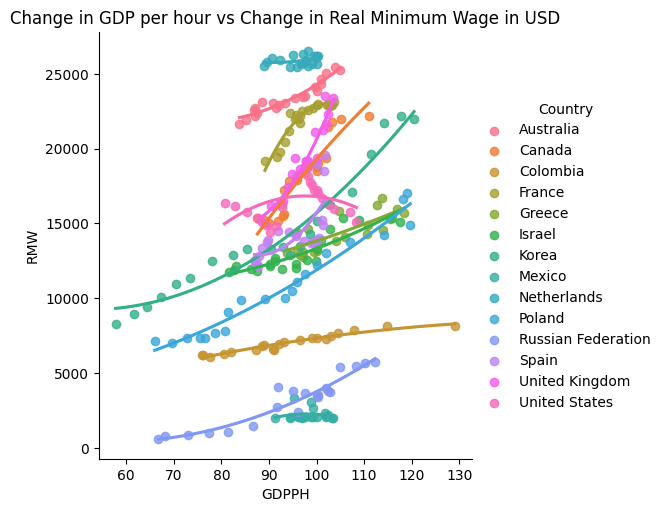

In [141]:
# GDP per hour

sns.lmplot(x="GDPPH", y="RMW", data=df_panel, hue='Country',
   order=2, ci=False).set(title=                 
                'Change in GDP per hour vs Change in Real Minimum Wage in USD')

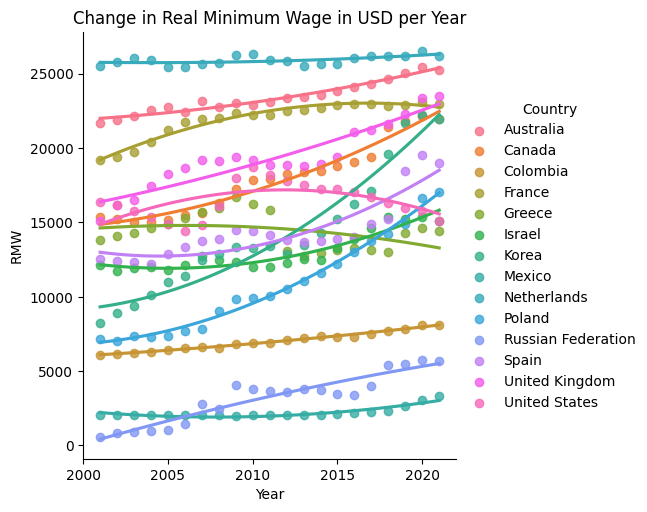

In [142]:
# Real Minimum Wage per year
import seaborn as sns
import pandas as pd
df_panel = pd.read_csv('realwage2.csv')

sns.lmplot(x="Year", y="RMW", data=df_panel, hue='Country',
   order=2, ci=False).set(title=                 
                'Change in Real Minimum Wage in USD per Year')